## Goodreads PMF Recommender
In this project a **PMF** (Probabilistic Matrix Factorization) Recommender is implemented in order to recommend books to users.    
  
Datasets that are used in this project can be found [here](https://github.com/zygmuntz/goodbooks-10k).
### Importing Libraries

In [1]:
import random
import numpy as np
import pandas as pd
import os.path as path
from tempfile import mkdtemp
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

/home/ghazal/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


### Defining Constants

In [2]:
RATING = 3
USER_ID = 1
BOOK_ID = 2
TRAIN_SIZE = 0.9
DATASETS_PATH = 'Datasets'

### Importing Data

In [3]:
def load_dataset(filename):
    dataset_file = path.join(DATASETS_PATH, filename)
    dataset = pd.read_csv(dataset_file)
    return dataset

In [4]:
ratings = load_dataset('ratings.csv')
n_users = ratings.user_id.unique().shape[0]
n_books = ratings.book_id.unique().shape[0]

### Creating User-Item Matrices

In [5]:
def create_rating_matrices(train_size):
    user_to_row = {}
    book_to_column = {}
    ratings_values = ratings.values
    n_dims = 10
    parameters = {}
    
    uniq_users = np.unique(ratings_values[:, USER_ID])
    uniq_books = np.unique(ratings_values[:, BOOK_ID])

    for i, user_id in enumerate(uniq_users):
        user_to_row[user_id] = i

    for j, book_id in enumerate(uniq_books):
        book_to_column[book_id] = j
    
    R_file = path.join(mkdtemp(), 'r.dat')
    R = np.memmap(R_file, dtype='float64', mode='w+', shape=(n_users, n_books))
    
    ratings_copy = ratings.copy()
    train = ratings_copy.sample(frac=train_size, random_state=0)
    test = ratings_copy.drop(train.index)
    
    for row in train.itertuples():
        i = user_to_row[row[USER_ID]]
        j = book_to_column[row[BOOK_ID]]
        R[i, j] = row[RATING]

    return R, train, test, n_dims, n_users, n_books, user_to_row, book_to_column

In [6]:
R_file = path.join(mkdtemp(), 'r.dat')
R = np.memmap(R_file, dtype='float64', mode='w+', shape=(n_users, n_books))

R, train, test, n_dims, n_users, n_books, user_to_row, book_to_column = create_rating_matrices(TRAIN_SIZE)
parameters = {}

### Basic Statistical Details of Training Data

In [7]:
train.describe()

user_id       book_id        rating
count  5.378831e+06  5.378831e+06  5.378831e+06
mean   2.622388e+04  2.006551e+03  3.919899e+00
std    1.541377e+04  2.468730e+03  9.912320e-01
min    1.000000e+00  1.000000e+00  1.000000e+00
25%    1.281500e+04  1.980000e+02  3.000000e+00
50%    2.593700e+04  8.850000e+02  4.000000e+00
75%    3.950800e+04  2.973000e+03  5.000000e+00
max    5.342400e+04  1.000000e+04  5.000000e+00

### Histogram of Ratings in Training Data

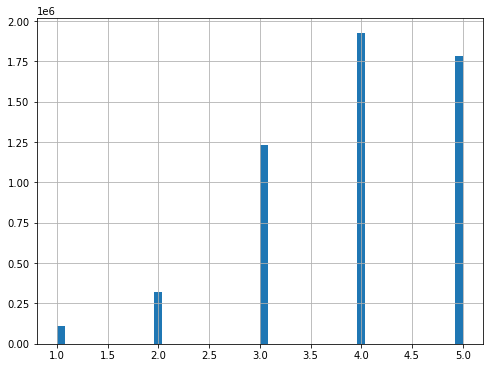

In [8]:
train['rating'].hist(figsize=(8.0, 6), bins=50)
plt.show()

### Concise Summary of Training Data 

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5378831 entries, 4220704 to 2030416
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 164.1 MB


In [10]:
train.head()

user_id  book_id  rating
4220704    19082     3851       5
2969973     7714     7228       3
1736216    24341     3710       5
5330206    53116     3459       3
5365781    52796     1053       5

In [11]:
def initialize_parameters(lambda_U, lambda_V):
    U = np.zeros((n_dims, n_users), dtype=np.float64)
    V = np.random.normal(0.0, 1.0 / lambda_V, (n_dims, n_books))
    
    parameters['U'] = U
    parameters['V'] = V
    parameters['lambda_U'] = lambda_U
    parameters['lambda_V'] = lambda_V

### Updating Parameters

\begin{equation}
\large
U_i=\left[\left(V_jV_j^T\right)_{j\in\Omega_{U_i}}+\lambda_UI\right]^{-1}\left(R_{ij}V_j^T\right)_{j\in\Omega_{U_i}}
\end{equation}

\begin{equation}
\large
V_j=\left[\left(U_iU_i^T\right)_{i\in\Omega_{V_j}}+\lambda_VI\right]^{-1}\left(R_{ij}U_i^T\right)_{i\in\Omega_{V_j}}
\end{equation}

In [12]:
def update_parameters():
    U = parameters['U']
    V = parameters['V']
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    
    for i in range(n_users):
        V_j = V[:, R[i, :] > 0]
        U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * \
                        np.identity(n_dims)), np.dot(R[i, R[i, :] > 0], V_j.T))
        
    for j in range(n_books):
        U_i = U[:, R[:, j] > 0]
        V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * \
                        np.identity(n_dims)), np.dot(R[R[:, j] > 0, j], U_i.T))
        
    parameters['U'] = U
    parameters['V'] = V

### Computing Log A Posteriori

\begin{equation}
\large
L=-\frac 1 2 \left(\sum_{i=1}^N\sum_{j=1}^M(R_{ij}-U_i^TV_j)_{(i,j) \in \Omega_{R_{ij}}}^2+\lambda_U\sum_{i=1}^N\|U_i\|_{Fro}^2+\lambda_V\sum_{j=1}^M\|V_j\|_{Fro}^2\right)
\end{equation}

In [13]:
def log_a_posteriori():
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    U = parameters['U']
    V = parameters['V']
    
    UV = np.dot(U.T, V)
    R_UV = (R[R > 0] - UV[R > 0])
    
    return -0.5 * (np.sum(np.dot(R_UV, R_UV.T)) + lambda_U * \
                   np.sum(np.dot(U, U.T)) + lambda_V * np.sum(np.dot(V, V.T)))

### Predicting Rating

In [14]:
def predict(user_id, book_id):
    U = parameters['U']
    V = parameters['V']
    
    r_ij = U[:, user_to_row[user_id]].T.reshape(1, -1) @ V[:, book_to_column[book_id]].reshape(-1, 1)

    max_rating = parameters['max_rating']
    min_rating = parameters['min_rating']

    return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) * 5.0

### Evaluating Prediction Accuarcy
**RMSE** (root mean squared error) is used as a metric to evaluate prediction accuracy. 

\begin{equation}
\large
RMSE=\sqrt{\frac{\sum_{ratings}^{}(P-R)^2}{\# ratings}}
\end{equation}

In [15]:
def evaluate(dataset):
    ground_truths = []
    predictions = []
    
    for row in dataset.itertuples():
        ground_truths.append(row[RATING])
        predictions.append(predict(row[USER_ID], row[BOOK_ID]))
    
    return mean_squared_error(ground_truths, predictions, squared=False)

In [16]:
def update_max_min_ratings():
    U = parameters['U']
    V = parameters['V']

    R = U.T @ V
    min_rating = np.min(R)
    max_rating = np.max(R)

    parameters['min_rating'] = min_rating
    parameters['max_rating'] = max_rating

### Trainig Model

In [17]:
def start_training(n_epochs):
    initialize_parameters(0.3, 0.3)
    log_aps = []
    rmse_train = []
    rmse_test = []

    update_max_min_ratings()
    rmse_train.append(evaluate(train))
    rmse_test.append(evaluate(test))
    
    for k in range(n_epochs):
        update_parameters()
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)

        if (k + 1) % 10 == 0:
            update_max_min_ratings()

            rmse_train.append(evaluate(train))
            rmse_test.append(evaluate(test))
            print('Log p a-posteriori at iteration', k + 1, ':', log_ap)

    update_max_min_ratings()

    return log_aps, rmse_train, rmse_test

In [ ]:
log_ps, rmse_train, rmse_test = start_training(150)

### Plotting Training Results

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title('Training results')
ax1.plot(np.arange(len(log_ps)), log_ps, label='MAP')
ax1.legend()

ax2.plot(np.arange(len(rmse_train)), rmse_train, label='RMSE train')
ax2.plot(np.arange(len(rmse_test)), rmse_test, label='RMSE test')
ax2.legend()

plt.show()

### Evaluating Model

In [ ]:
print('RMSE of training set:', evaluate(train))
print('RMSE of testing set:', evaluate(test))